In [1]:
import argparse
import logging
import os
import random
import pandas as pd
from dataclasses import dataclass
from itertools import chain
from typing import Optional, Union
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

import datasets
import torch
from datasets import load_dataset, load_metric, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import transformers
from accelerate import Accelerator
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    PreTrainedTokenizerBase,
    default_data_collator,
    DataCollatorForSeq2Seq,
    AdamW,
    SchedulerType,
    get_scheduler,
    set_seed,
)
from transformers.file_utils import PaddingStrategy
from promptsource.templates import DatasetTemplates
pd.set_option("display.max_rows", 1200)


/opt/conda/envs/tz/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 1000
model_dir = "output_1000_plus"
df = pd.read_csv(f'/home/gikok/{model_dir}/stats_{n}.csv')
# accuracy = np.zeros(n-1)
# for i in range(1, n):
#     temp = pd.read_csv(f'/home/gikok/{model_dir}/stats_{i}.csv')
#     accuracy[i-1] = temp['accuracy'].iloc[0]
# model_dir = "output"
# df2 = pd.read_csv(f'/home/gikok/{model_dir}/stats_{n}.csv')
# accuracy2 = np.zeros(n-1)
# for i in range(1, n):
#     temp = pd.read_csv(f'/home/gikok/{model_dir}/stats_{i}.csv')
#     accuracy2[i-1] = temp['accuracy'].iloc[0]
# # model_dir = "output2"
# # df3 = pd.read_csv(f'/home/gikok/{model_dir}/stats_{n}.csv')
# # accuracy3 = np.zeros(n-1)
# # for i in range(1, n):
# #     temp = pd.read_csv(f'/home/gikok/{model_dir}/stats_{i}.csv')
# #     accuracy3[i-1] = temp['accuracy'].iloc[0]
    

In [4]:
df.to_csv(f'/home/gikok/{model_dir}/stats.csv')

In [17]:
n = 342
model_dir = "output_no_GA"
df = pd.read_csv(f'/home/gikok/{model_dir}/stats.csv')
even = np.arange(0, len(df)-1, 2)
even1 = np.arange(1, len(df), 2)
df1 = df.iloc[even]
df2 = df.iloc[even1]

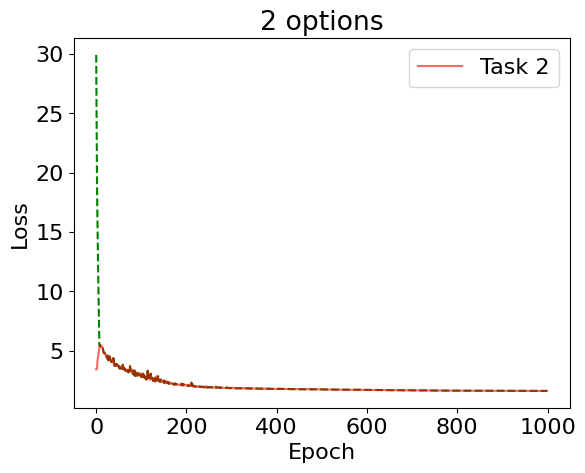

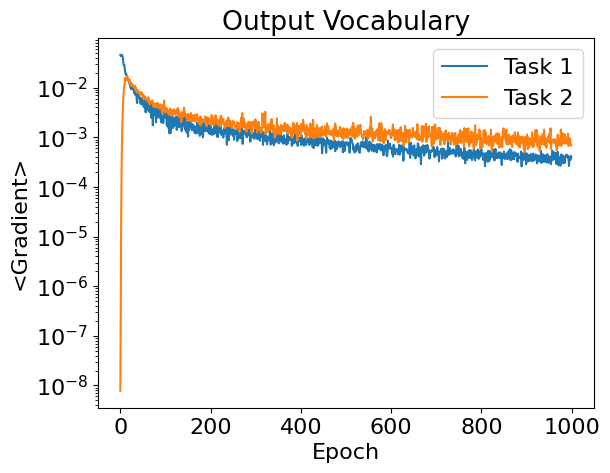

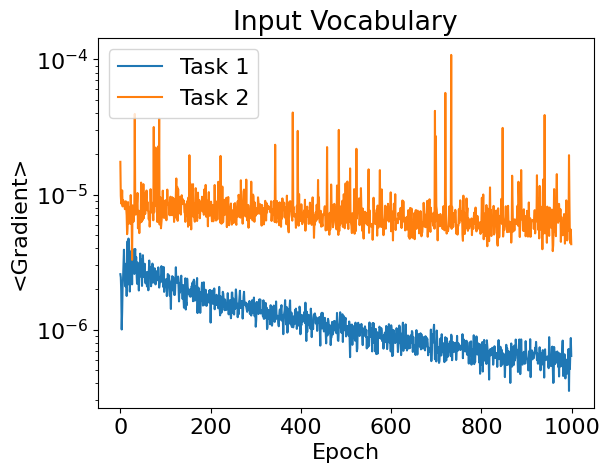

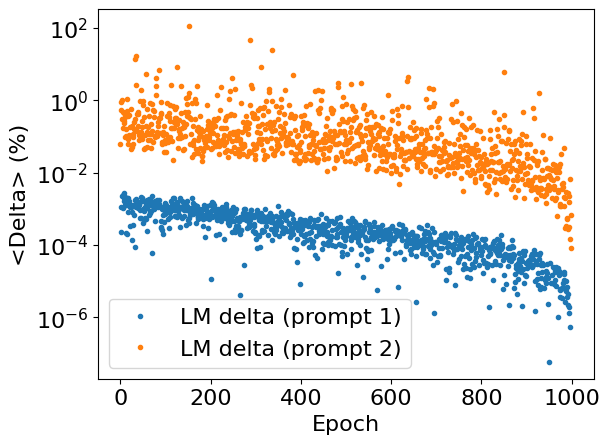

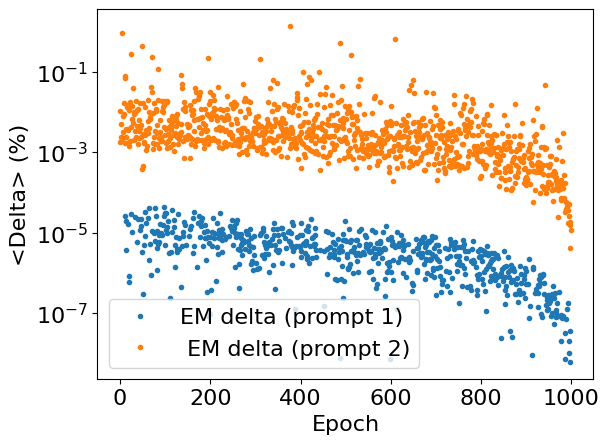

In [21]:
e = df.groupby(df.index//200).median()
et =  df.groupby(df.index//200).max()
eb =  df.groupby(df.index//200).quantile(0.25)
e2 = df2.groupby(df2.index//200).max()
et2 =  df2.groupby(df2.index//200).quantile(0.75)
eb2 =  df2.groupby(df2.index//200).quantile(0.25)
l = np.arange(len(e))
plt.rcParams['font.size'] = 16
# plt.plot(l, e["training_loss"], label = 'Task 1', c='green')
plt.plot(l, et["test_loss"], c='green', ls='--')
# plt.plot(l, eb["training_loss"], c='green', ls='--')

plt.plot(l, e2["test_loss"], label = 'Task 2', c='red', alpha=0.6)
# plt.plot(l, et2["training_loss"], c='red', ls='--')
# plt.plot(l, eb2["training_loss"], c='red', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("2 options")
#plt.ylim(3e-1, 10)
plt.legend()
# plt.yscale('log')
plt.show()
plt.plot(l, abs(e["lm_grad_pct"]), label = 'Task 1')
plt.plot(l, abs(e2["lm_grad_pct"]), label = 'Task 2')
plt.xlabel('Epoch')
plt.yscale('log')
plt.title("Output Vocabulary")
plt.ylabel('<Gradient>')
plt.legend()
#plt.yscale('log')
plt.show()
plt.plot(l, abs(e["em_grad_pct"]), label= 'Task 1')
plt.plot(l, abs(e2["em_grad_pct"]), label='Task 2')
plt.xlabel('Epoch')
plt.ylabel('<Gradient>')
plt.title("Input Vocabulary")
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, e["lm_delta_pct"], '.', label = 'LM delta (prompt 1)')
plt.plot(l, e2["lm_delta_pct"], '.', label = 'LM delta (prompt 2)')
plt.xlabel('Epoch')
#plt.ylim([-0.2, 0.2])
plt.ylabel('<Delta> (%)')
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, e["em_delta_pct"], '.', label= 'EM delta (prompt 1)')
plt.plot(l, e2["em_delta_pct"], '.', label=' EM delta (prompt 2)')
plt.xlabel('Epoch')
#plt.ylim([-2e-3, 2e-3])
plt.ylabel('<Delta> (%)')
plt.legend()
plt.yscale('log')
plt.show()

In [2]:
torch.cuda.device_count()

8

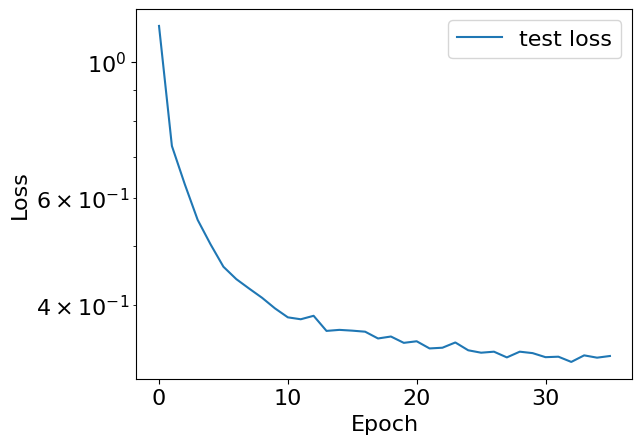

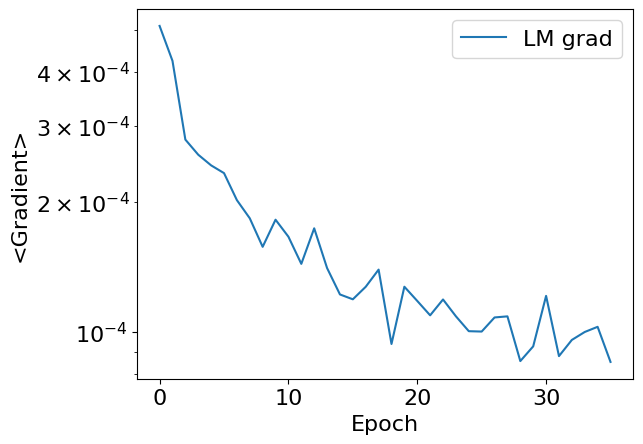

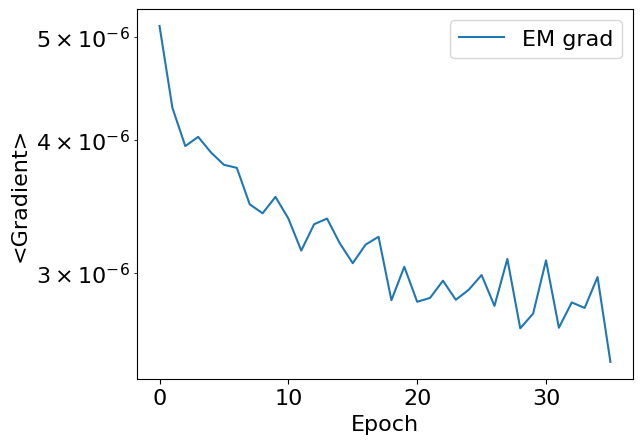

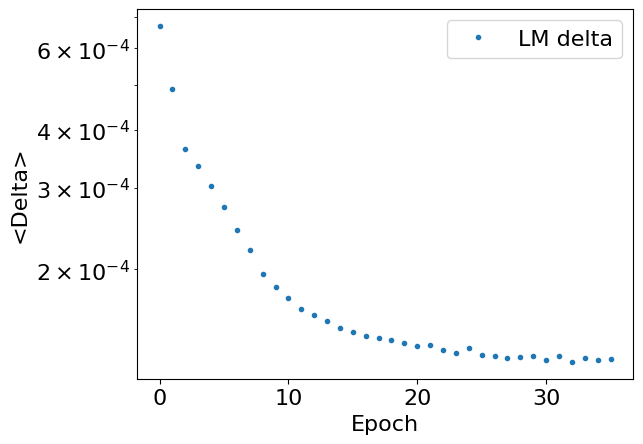

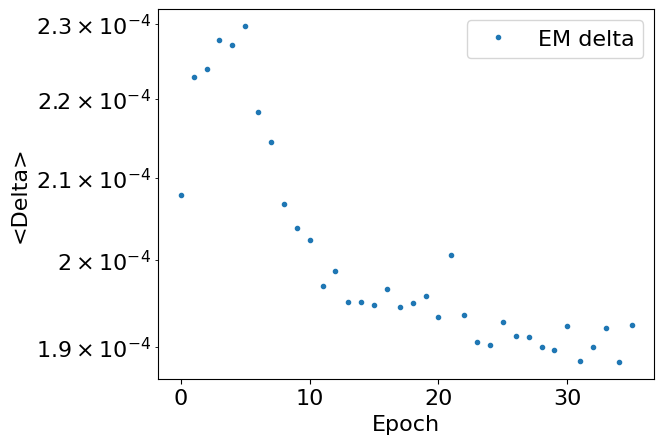

In [6]:
n = 34
model_dir = "shuffle"
df = pd.read_csv(f'/home/gikok/{model_dir}/stats_{n}.csv')
e = df.groupby(df.index//25).mean()
l = np.arange(len(e))
plt.plot(l, e["training_loss"], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, abs(e["lm_grad_pct"]), label = 'LM grad')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('<Gradient>')
plt.legend()
#plt.yscale('log')
plt.show()
plt.plot(l, abs(e["em_grad_pct"]), label= 'EM grad')
plt.xlabel('Epoch')
plt.ylabel('<Gradient>')
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, e["lm_delta_pct"], '.', label = 'LM delta')
plt.xlabel('Epoch')
#plt.ylim([-0.2, 0.2])
plt.ylabel('<Delta>')
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, e["em_delta_pct"], '.', label= 'EM delta')
plt.xlabel('Epoch')
#plt.ylim([-2e-3, 2e-3])
plt.ylabel('<Delta>')
plt.legend()
plt.yscale('log')
plt.show()

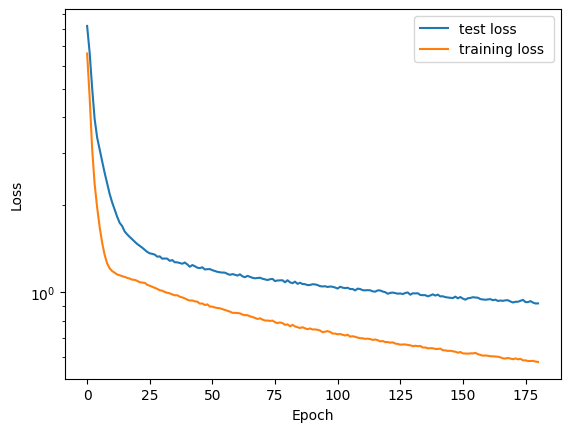

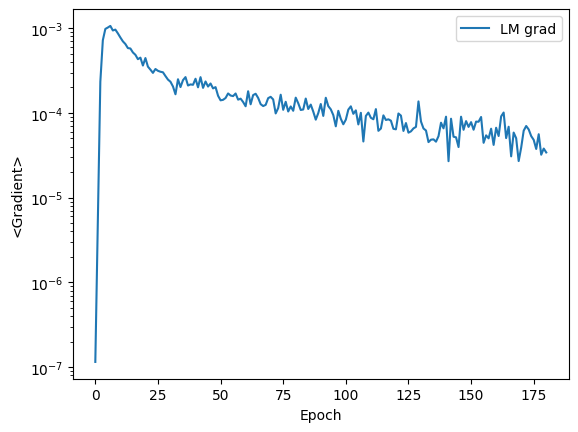

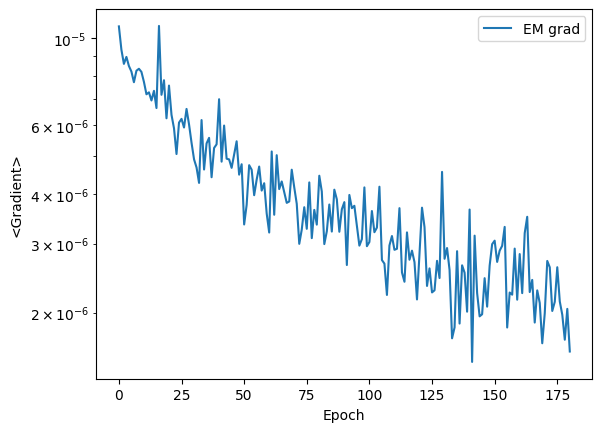

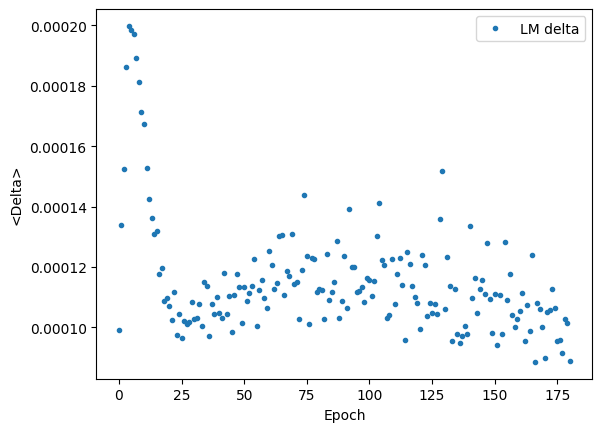

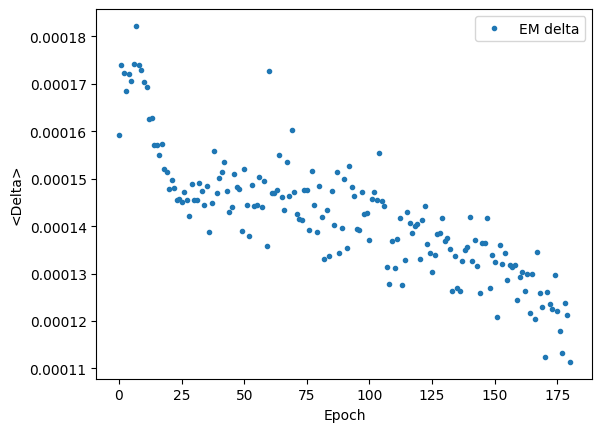

In [6]:
n = 181
model_dir = "output_new_p2"
df = pd.read_csv(f'/home/gikok/{model_dir}/stats_{n}.csv')
e = df.groupby(df.index//100).mean()
l = np.arange(len(e))
plt.plot(l, e["training_loss"], label='test loss')
plt.plot(l, e["test_loss"], label = 'training loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, abs(e["lm_grad_pct"]), label = 'LM grad')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('<Gradient>')
plt.legend()
#plt.yscale('log')
plt.show()
plt.plot(l, abs(e["em_grad_pct"]), label= 'EM grad')
plt.xlabel('Epoch')
plt.ylabel('<Gradient>')
plt.legend()
plt.yscale('log')
plt.show()
plt.plot(l, e["lm_delta_pct"], '.', label = 'LM delta')
plt.xlabel('Epoch')
#plt.ylim([-0.2, 0.2])
plt.ylabel('<Delta>')
plt.legend()
#plt.yscale('log')
plt.show()
plt.plot(l, e["em_delta_pct"], '.', label= 'EM delta')
plt.xlabel('Epoch')
#plt.ylim([-2e-3, 2e-3])
plt.ylabel('<Delta>')
plt.legend()
#plt.yscale('log')
plt.show()

In [3]:
#Load model and tokenizer

model_name = "bigscience/T0pp"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Model and tokenizer loaded")

model.parallelize()
print("Moved model to GPUs")



Model and tokenizer loaded
Moved model to GPUs


In [17]:
inp = "is a whale an animal?"
inputs = tokenizer.encode(
    inp, return_tensors='pt')
inputs = inputs.to("cuda:0")
with torch.no_grad():
    outputs = model.generate(inputs)
print("Q: " + inp)
print("A: " + tokenizer.decode(outputs[0], skip_special_tokens=True))

Q: is a whale an animal?
A: Yes


In [15]:
inp = "What is the top speed of a leopard?"
inputs = tokenizer.encode(
    inp, return_tensors='pt')
inputs = inputs.to("cuda:0")
with torch.no_grad():
    outputs = model.generate(inputs)
print("Q: " + inp)
print("A: " + tokenizer.decode(outputs[0], skip_special_tokens=True))

Q: What is the top speed of a leopard?
A: 4.5 mph


/opt/conda/envs/tz/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == "__main__":
/opt/conda/envs/tz/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


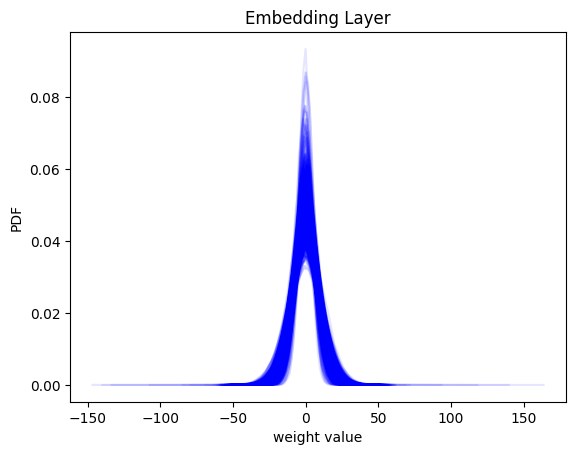

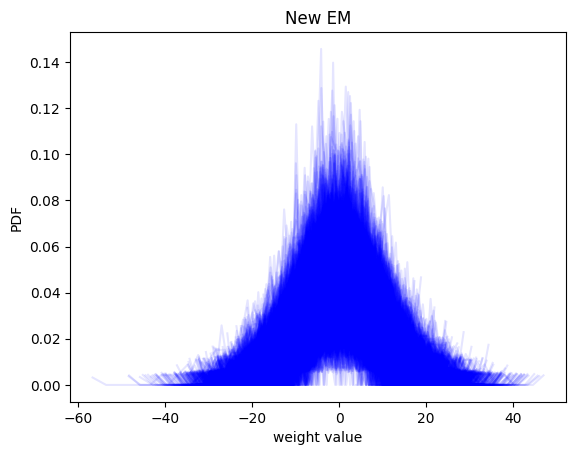

/opt/conda/envs/tz/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/opt/conda/envs/tz/lib/python3.7/site-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


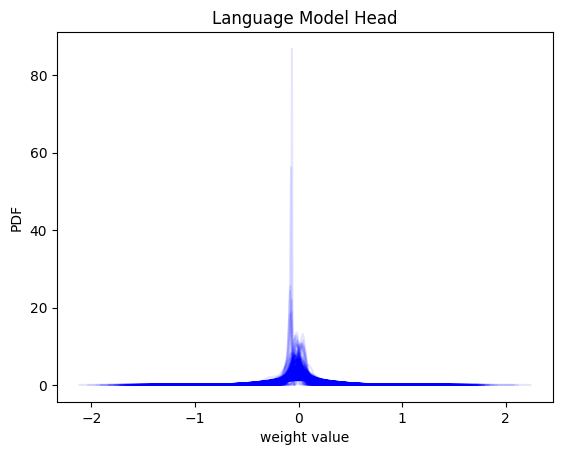

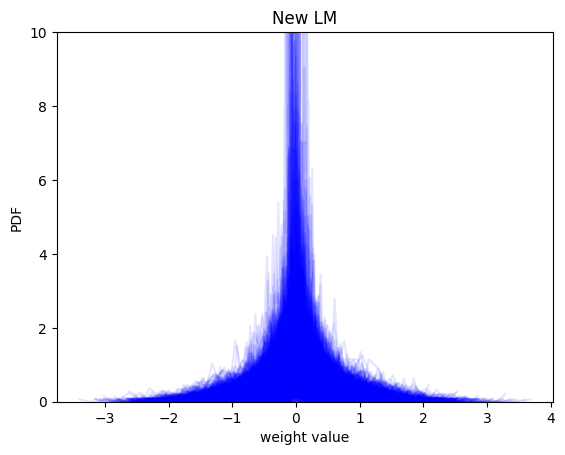

In [100]:
embeddings = list(model.named_parameters())[0][1]
lm_head = list(model.named_parameters())[-1][1]
n_new = 100
og = embeddings[:-n_new,:].detach().cpu()
new = embeddings[-n_new:,:].detach().cpu()
og_vals = np.zeros((2048, 30))
og_bins = np.zeros((2048, 30))
for i in range(2048):
    val, bin = np.histogram(og[:,i], 30, normed=True)
    og_vals[i] = val
    og_bins[i] = (bin[1:]+bin[:-1])/2
new_vals = np.zeros((2048, 30))
new_bins = np.zeros((2048, 30))
for i in range(2048):
    val, bin = np.histogram(new[:,i], 30, normed=True)
    new_vals[i] = val
    new_bins[i] = (bin[1:]+bin[:-1])/2
for i in range(2048):
    plt.plot(og_bins[i], og_vals[i], c='blue', alpha=0.1)
plt.xlabel('weight value')
plt.ylabel('PDF')
plt.title("Embedding Layer")
plt.show()
for i in range(2048):
    plt.plot(new_bins[i], new_vals[i], c='blue', alpha=0.1)
plt.xlabel('weight value')
plt.ylabel('PDF')
plt.title("New EM")
plt.show()
n_new = 100
og = lm_head[:-n_new,:].detach().cpu()
new = lm_head[-n_new:,:].detach().cpu()
og_vals = np.zeros((2048, 30))
og_bins = np.zeros((2048, 30))
for i in range(2048):
    val, bin = np.histogram(og[:,i], 30, normed=True)
    og_vals[i] = val
    og_bins[i] = (bin[1:]+bin[:-1])/2
new_vals = np.zeros((2048, 30))
new_bins = np.zeros((2048, 30))
for i in range(2048):
    val, bin = np.histogram(new[:,i], 30, normed=True)
    new_vals[i] = val
    new_bins[i] = (bin[1:]+bin[:-1])/2
for i in range(2048):
    plt.plot(og_bins[i], og_vals[i], c='blue', alpha=0.1)
plt.xlabel('weight value')
plt.ylabel('PDF')
#plt.ylim(0, 15)
plt.title("Language Model Head")
plt.show()
for i in range(2048):
    plt.plot(new_bins[i], new_vals[i], c='blue', alpha=0.1)
plt.xlabel('weight value')
plt.ylabel('PDF')
plt.ylim(0, 10)
plt.title("New LM")
plt.show()

In [15]:
df = pd.read_parquet('data/miniprompts005.parquet.gzip')
items = pd.read_parquet("data/item_no_100.parquet.gzip")["item_no"].values.tolist()
w = 1123
print(df['input'].iloc[w][:-12] + ", " + ', '.join(items))
print(df['target'].iloc[w])
print(items.remove(items[0]))


query: 'solid oak table'
for the query above, what item_no is the correct match? 60404098, 00291626, 09478243, 89227731, 50401335 , 70286768, 50402033, 50507469, 10402501, 50401335, 99429408, 00286385, 90510605, 50055863, 80456680, 99281794, 80265275, 60414078, 20456664, 80511436, 70186113, 00475786, 40476816, 79418986, 80294503, 39417074, 09416113, 50269369, 10511208, 09285070, 10435926, 49476794, 70216577, 99392235, 90362884, 69285005, 99412219, 00291626, 99432057, 30260869, 09410371, 49194105, 20472918, 19432457, 79331511, 60212570, 29321010, 89330002, 29178007, 09328890, 09478243, 30493350, 20476167, 20431602, 89227731, 10411242, 90503935, 29398844, 90452304, 40449639, 09251348, 00513378, 89335995, 10440452, 19321063, 29010975, 39442709, 69227671, 90479285, 60419957, 00503794, 89328344, 30507875, 80253809, 20285035, 50238858, 59308333, 19282679, 20366296, 99291745, 80466288, 10498179, 60404098, 30340833, 60282332, 20434832, 40360222, 50460018, 80298474, 70431893, 50434114, 50434232

In [78]:
30493350, 2047617

torch.Size([32200, 4096])

In [87]:
w = 1123
items = pd.read_parquet("data/item_no_100.parquet.gzip")["item_no"].values.tolist()
#items.remove('30493350')
inp1 = "what is the similarity between 30493350 and 2047617?"
#inp1 = inp1  + ', '.join(items)
#inp = "99429408 and 50401335 are dining tables. is the previous sentence correct? yes or no?"
inputs = tokenizer.encode(
    inp1, return_tensors='pt')
inputs = inputs.to("cuda:0")
with torch.no_grad():
    outputs = model.generate(inputs)
print("Q: " + inp1)
print("A: " + tokenizer.decode(outputs[0], skip_special_tokens=True)[:8])

Q: what is the similarity between 30493350 and 2047617?
A: 2047617 


In [88]:
names = pd.read_parquet("data/item_names_100.parquet.gzip").values.tolist()
for i, item in enumerate(names):
    for j, ittem in enumerate(names):
        inp = f"what is the similarity between {item[0]} and {ittem[0]}?"
        inputs = tokenizer.encode(
            inp, return_tensors='pt')
        inputs = inputs.to("cuda:0")
        with torch.no_grad():
            outputs = model.generate(inputs)
        print(i, item[1], ittem[1])
        print("Q: " + inp)
        print("A: " + tokenizer.decode(outputs[0], skip_special_tokens=True))
        print("")
        print("")
    print("**************************************************************")
    print("")

/opt/conda/envs/tz/lib/python3.7/site-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


0 lomviken frame black lomviken frame black
Q: what is the similarity between 70286768 and 70286768?
A: 50460018 is a90362884 prefix


0 lomviken frame black kalanchoe potted plant with pot kalanchoe assorted colours
Q: what is the similarity between 70286768 and 50402033?
A: 50402033 is a religious ceremony


0 lomviken frame black elsabet throw handmade stripe light red pink
Q: what is the similarity between 70286768 and 50507469?
A: 50507469 is a word that means50507469.


0 lomviken frame black fantastisk paper napkin dark red
Q: what is the similarity between 70286768 and 10402501?
A: Words that are pronounced the same but have different meanings


0 lomviken frame black moeckelby table oak
Q: what is the similarity between 70286768 and 50401335?
A: 50460018 is a90362884 prefix


0 lomviken frame black ekedalen table and 2 chairs white hakebo beige
Q: what is the similarity between 70286768 and 99429408?
A: 50460018 is a90362884 prefix


0 lomviken frame black gullklocka cushion c

In [4]:
items = pd.read_parquet("data/item_no_100.parquet.gzip")["item_no"].values.tolist()
l = ["furniture", "couch", "sofa", "chair", "shelf", "kitchen", "table", "bed"]
inputs = tokenizer.batch_encode_plus(
    l, return_tensors="pt", padding=True
).to('cuda:0')
inds = torch.tensor([inputs['input_ids'][i].max() for i in range(len(l))])
inds
emb = list(model.named_parameters())[0][1]
lm = list(model.named_parameters())[-1][1]
v = emb[:-100]
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
item_no = []
item_name = []
#tt = emb[inds]
tt = emb[-100:]
top10 = []
for i in range(len(tt)):
    print(i)
    top = []
    r = []
    t = tt[i]
    for j in range(len(v)):
        vv = v[j]
        r += [cos(t, vv)]
    nn = torch.tensor(r).topk(10, largest=True)
    top10 += [[tokenizer.decode(nn[1], skip_special_tokens=False)]]
print(top10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[['Melbourne 3/4 omului examine Geneva scenic gourmet Gourmet scalp Tempe'], ['religion Religion environmental agricultural religious biologique probleme landscape Bible Romania'], ['investment pirate Muslim platinum Platinum Prague RFID throwing Disaster ancient'], ['enţă hypothesis promis prévention fraudulent Timişoara Constanțaţţi crede'], ['Professor Lisa Jorge Fritz Ernst Steve romanticbelievableschlafarchitecte'], ['entreprises românească miraculous produced produces achieve Displayprésident enjoyable computing'], ['cushion cushions Cushion confidence Conservation Cliff cautious decisiv clutch courageous'], ['mijloace Modell consequential Adjust cushion compensate conceal Logistik Regierung rem

In [5]:
items = pd.read_parquet("data/item_no_100.parquet.gzip")["item_no"].values.tolist()
emb = list(model.named_parameters())[0][1]
lm = list(model.named_parameters())[-1][1]
v = lm[:-100]
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
item_no = []
item_name = []
#tt = lm[inds]
tt = lm[-100:]
top102 = []
for i in range(len(tt)):
    print(i)
    top = []
    r = []
    t = tt[i]
    for j in range(len(v)):
        vv = v[j]
        r += [cos(t, vv)]
    nn = torch.tensor(r).topk(10, largest=True)
    top102 += [[tokenizer.decode(nn[1], skip_special_tokens=True)]]
#     print("huh")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [6]:
queries = pd.read_parquet("data/item_namequeries100.parquet.gzip")
#add = pd.DataFrame({'item_no':['ikea_item_no'], 'name':['-'], 'top10 queries': ['-']})
#queries = pd.concat([add, queries])
df = pd.DataFrame({'item_no':items,'top_10_input':top10, 'top_10_output':top102})
df = df.merge(queries, how='inner', on='item_no')

In [11]:
ddf = df[['item_no', 'name', 'top_10_input', 'top_10_output','top10 queries']]

In [10]:
df

item_no                                       top_10_input  \
0   70286768  [Melbourne 3/4 omului examine Geneva scenic go...   
1   50402033  [religion Religion environmental agricultural ...   
2   50507469  [investment pirate Muslim platinum Platinum Pr...   
3   10402501  [enţă hypothesis promis prévention fraudulent ...   
4   50401335  [Professor Lisa Jorge Fritz Ernst Steve romant...   
5   99429408  [entreprises românească miraculous produced pr...   
6   00286385  [cushion cushions Cushion confidence Conservat...   
7   90510605  [mijloace Modell consequential Adjust cushion ...   
8   50055863  [drama ancient advanced paysage mixture questi...   
9   80456680  [espagnol sonore breakout truth cities Racing ...   
10  99281794  [achievement überzeugen réussite profile clini...   
11  80265275  [fireplace 1983 Sheet responsibility spine mus...   
12  60414078  [rugămpeptidEPAGPEntwickler planting biopsy Gu...   
13  20456664  [copiii flagship Social enemies employer parin...   
14  80511436  [multinationalilliersizarea 10,000 sufletheadq...   
15  70186113  [FifthVoilà $50 CristinaCertaineincredibly Lib...   
16  00475786  [projetPM Wellington Melbourne propose paradis...   
17  40476816  [mémoire Creek creek guilt torque refrigeratio...   
18  79418986  [coherent fabricant calitatea rafina Joomla sc...   
19  80294503  [ţional189specialisedamenajare niedrigelectriq...   
20  39417074  [Glück chantier Leg struck Lambert defendant S...   
21  09416113  [histories underestimateaceastă traumhaft docu...   
22  50269369  [Coffee Nousacordul coffee coconut Professiona...   
23  10511208  [earth palate tasty delicious robust plastic s...   
24  09285070  [ships ciclattack Shopping shop eCommerce ship...   
25  10435926  [Global 1929 alegeril Garant italian naz Louis...   
26  49476794  [unleash auszu enterprises platforms proprieta...   
27  70216577  [Société Château Marseille Gloucester assembli...   
28  99392235  [seafood talented Scientist exceptional Chicke...   
29  90362884  [biblicalkämpfeGregororial888 coton gelungen T...   
30  69285005  [manufacture trademark consommation electrical...   
31  99412219  [etapa mangoUnsereputeti Nous Diana Gelände To...   
32  00291626  [luft Silicon Springfield Navigation siliconuş...   
33  99432057  [Italien Psycho medical Estate deceased singer...   
34  30260869  [Belgium Expedition plywood Spotifymarkt patie...   
35  09410371  [butterfly (2013)2002spannung permetpolitische...   
36  49194105  [Titan ******* Cred cred cântunit Comun membri...   
37  20472918  [patrimoine Scandinavia MadagascarSeptember mu...   
38  19432457  [Schönktuell possédriya Huaweizustellen schönb...   
39  79331511  [obeyfluss integerFunktion ecosystem Kopf Allt...   
40  60212570  [Mouse Chicago Hamilton Katie Springfield chan...   
41  29321010  [Kunststoff cybersecurity Garant confectionBan...   
42  89330002  [schizophrenia replica București panic Barbara...   
43  29178007  [Wechselprüfung phaseSIC Ablauf yourself patch...   
44  09328890  [simpati Practice fabriqu scène Château Moscow...   
45  09478243  [PortfolioErlebnisBiserica Schokolade compéten...   
46  30493350  [think culturesrandomizedHonestly financially ...   
47  20476167  [communicate nonprofit magicopathic Baptistest...   
48  20431602  [April Windows vitaminktuellApril SQL pinteres...   
49  89227731  [Son students postcard Peru degree student pat...   
50  10411242  [detailed ConsultingPalatulvruKü dynamique pre...   
51  90503935  [Scandinaviaesthétique Attack dynamique ecosys...   
52  29398844  [Rechnung Nachricht diseasesţie Salesforcefolg...   
53  90452304  [acquisition equitable Alma demandeculturemăéc...   
54  40449639  [BlackBlack revenge homeowners South detective...   
55  09251348  [Chairman Timothy Wednesdayaccompagnement chai...   
56  00513378  [relatives personnelle remarquable spécialgesp...   
57  89335995  [Fritz Excel biologique espresso Joyce vocabul...   
58  10440452  [articol Baltic diversity Fantasy arch

In [12]:
ddf.to_excel('cosine_similarity_large_800_epochq.xlsx')

In [174]:
top3 = []
top3n = 100*[[]]
for i, j in enumerate(top10):
    top3 = [j[0][0:8], j[0][8:16], j[0][16:]]
    top3n[i] = [queries[queries['item_no']==top3[0]]['name'].iloc[0], queries[queries['item_no']==top3[1]]['name'].iloc[0], queries[queries['item_no']==top3[2]]['name'].iloc[0]] 


In [178]:
top3 = []
top32n = 100*[[]]
for i, j in enumerate(top102):
    top3 = [j[0][0:8], j[0][8:16], j[0][16:]]
    top32n[i] = [queries[queries['item_no']==top3[0]]['name'].iloc[0], queries[queries['item_no']==top3[1]]['name'].iloc[0], queries[queries['item_no']==top3[2]]['name'].iloc[0]] 

In [162]:
queries[queries['item_no']=='70286768']['name'].iloc[0]

'lomviken frame black'

In [173]:
queries[queries['item_no']==top3[2]]['name'].iloc[0]

'billy oxberg bookcase with glass doors black brown'

In [185]:
df = pd.DataFrame({'item':names,'top_3_input':top3n, 'top_3_output':top32n})


In [186]:
pd.set_option('display.max_colwidth', 1000)
df[['item', 'top_3_output']].head()

item  \
0                                        [70286768, lomviken frame black]   
1  [50402033, kalanchoe potted plant with pot kalanchoe assorted colours]   
2                [50507469, elsabet throw handmade stripe light red pink]   
3                            [10402501, fantastisk paper napkin dark red]   
4                                         [50401335, moeckelby table oak]   

                                                                                                                            top_3_output  
0                       [lerhyttan glass door black stained, enhet bs cb f wb w shlf door grey white frame, rakkestad shelf black brown]  
1        [fejka artificial potted plant in outdoor poppy red, gradvis plant pot pink, fejka artificial potted plant in outdoor monstera]  
2   [lenda curtains with tie backs 1 pair gray turquoise, kura reversible bed white pine, groenlid 3 seat sofa bed tallmyra medium grey]  
3                 [uppdatera utensil tray white, socker watering can in outdoor red, fejka artificial potted plant in outdoor poppy red]  
4  [ekedalen table and 2 chairs white hakebo beige, bekant table top black stained ash veneer, mammut childrens stool in outdoor yellow]

In [ ]:
em2

tensor([-11.9428348541259766,   3.0994832515716553, -12.8874444961547852,
         ..., -15.0370130538940430,  -8.4482536315917969,
          1.2140339612960815], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
5e-3*0.005

2.5e-05

In [ ]:
df.groupby('accuracy').size()

accuracy
0.80543    18988
dtype: int64

In [ ]:
df['training_loss'].tail()

34795    1.260383
34796    0.230239
34797    1.326845
34798    0.170693
34799    2.072440
Name: training_loss, dtype: float64